# Import package

In [2]:

!pip install xtarfile

  Preparing metadata (setup.py) ... done
  Created wheel for xtarfile: filename=xtarfile-0.2.1-py3-none-any.whl size=8056 sha256=86f472c770b75d04f8644e9346c0050052ff50b41cd07ee1fbce811a5bb6e29e
  Stored in directory: /root/.cache/pip/wheels/73/de/d6/def0eebfc3d5adb3a866d1bd9ae45649e07e6cffb284314a00
Successfully built xtarfile


In [3]:
START_TOKEN="\t"
END_TOKEN="\n"

In [4]:
# General Utilities
import os
from os.path import exists
import random
import time
import re
import string
import csv

# Numerical and Data Handling
import numpy as np
import pandas as pd
from collections import Counter

# Visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.font_manager import FontProperties

# Word Cloud
from wordcloud import WordCloud, STOPWORDS

# Machine Learning
import keras
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras.backend as K

In [5]:
"""
This module implements two types of attention mechanisms:
- Luong Attention
- Bahdanau Attention

Reference:
https://medium.com/deep-learning-with-keras/seq2seq-part-c-basic-encoder-decoder-a7f536f5f510
"""

# --- Luong Attention ---
class LuongAttention(tf.keras.layers.Layer):
    def __init__(self, units):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)

    def call(self, query, values):
        query_time = tf.expand_dims(query, axis=1)
        values_T = tf.transpose(values, perm=[0, 2, 1])
        score = tf.transpose(tf.matmul(query_time, values_T), perm=[0, 2, 1])
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

# --- Bahdanau Attention ---
class BahdanauAttention(tf.keras.layers.Layer):
    def __init__(self, units, verbose=0):
        super().__init__()
        self.W1 = layers.Dense(units)
        self.W2 = layers.Dense(units)
        self.V = layers.Dense(1)
        self.verbose = verbose

    def call(self, query, values):
        query_time = tf.expand_dims(query, 1)
        score = self.V(tf.nn.tanh(self.W1(query_time) + self.W2(values)))
        attention_weights = tf.nn.softmax(score, axis=1)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector, attention_weights

In [6]:
# import tensorflow as tf
# import random
# import numpy as np
# import os

# from os.path import exists
# import xtarfile as tarfile
# import pandas as pd
# import keras
# START_TOKEN="\t"
# END_TOKEN="\n"


# def downloadDataSet():
#    cwd = os.getcwd()

#    file_exists = exists('./dakshina_dataset_v1.0.tar')
#    if(file_exists==False):
#      print('downloading....')
#      os.system('curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dakshina_dataset_v1.0.tar')
#      print('download Complete')
#    extract_exists = exists('./dakshina_dataset_v1.0/')
#    if(extract_exists==False):
#      print('Extracting..')
#      with tarfile.open('dakshina_dataset_v1.0.tar', 'r') as archive:
#          archive.extractall()
#      print('Complete')
#    print('You are all set')
# def get_files(language):

#   train_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.train.tsv'
#   val_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.dev.tsv'
#   test_dir='./dakshina_dataset_v1.0/'+language+'/lexicons/'+language+'.translit.sampled.test.tsv'

#   return train_dir, val_dir, test_dir

# def tokenize(lang,tokenizer=None):
#     """ Uses tf.keras tokenizer to tokenize the data/words into characters
#     """
#     if(tokenizer==None):
#         tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
#         tokenizer.fit_on_texts(lang)
#         lang_tensor = tokenizer.texts_to_sequences(lang)
#         lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
#                                                             padding='post')
#     else:

#         lang_tensor = tokenizer.texts_to_sequences(lang)
#         lang_tensor = tf.keras.preprocessing.sequence.pad_sequences(lang_tensor,
#                                                         padding='post')

#     return lang_tensor, tokenizer
# def preprocess_data(fpath,ip_tokenizer=None, tgt_tokenizer=None):

#     #Read data from files
#     df = pd.read_csv(fpath, sep="\t", header=None)

#     #Add start and end token
#     df[0] = df[0].apply( lambda x:START_TOKEN+x+END_TOKEN)
#     ip_tensor, ip_tokenizer = tokenize(df[1].astype(str).tolist(), tokenizer=ip_tokenizer)

#     tgt_tensor, tgt_tokenizer = tokenize(df[0].astype(str).tolist(), tokenizer=tgt_tokenizer)

#     dataset = tf.data.Dataset.from_tensor_slices((ip_tensor, tgt_tensor))
#     dataset = dataset.shuffle(len(dataset))

#     return dataset, ip_tokenizer, tgt_tokenizer





In [7]:
import tensorflow as tf
import numpy as np
import random
import os
from os.path import exists
import pandas as pd
import keras
import xtarfile as tarfile

START_TOKEN = "\t"
END_TOKEN = "\n"

def downloadDataSet():
    cwd = os.getcwd()
    if not exists('./dakshina_dataset_v1.0.tar'):
        print("downloading....")
        os.system('curl -SL https://storage.googleapis.com/gresearch/dakshina/dakshina_dataset_v1.0.tar > dakshina_dataset_v1.0.tar')
        print("download complete")

    if not exists('./dakshina_dataset_v1.0/'):
        print("extracting...")
        with tarfile.open('dakshina_dataset_v1.0.tar', mode='r') as archive:
            archive.extractall()
        print("extraction complete")

    print("You are all set.")

def get_files(language):
    base_path = f'./dakshina_dataset_v1.0/{language}/lexicons/'
    return (
        f'{base_path}{language}.translit.sampled.train.tsv',
        f'{base_path}{language}.translit.sampled.dev.tsv',
        f'{base_path}{language}.translit.sampled.test.tsv'
    )

def tokenize(lang, tokenizer=None):
    """Tokenizes characters using Keras tokenizer"""
    if tokenizer is None:
        tokenizer = tf.keras.preprocessing.text.Tokenizer(char_level=True)
        tokenizer.fit_on_texts(lang)

    sequences = tokenizer.texts_to_sequences(lang)
    padded = tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')
    return padded, tokenizer

def preprocess_data(fpath, ip_tokenizer=None, tgt_tokenizer=None):
    df = pd.read_csv(fpath, sep='\t', header=None)
    df[0] = df[0].apply(lambda x: START_TOKEN + x + END_TOKEN)

    ip_tensor, ip_tokenizer = tokenize(df[1].astype(str).tolist(), ip_tokenizer)
    tgt_tensor, tgt_tokenizer = tokenize(df[0].astype(str).tolist(), tgt_tokenizer)

    data = tf.data.Dataset.from_tensor_slices((ip_tensor, tgt_tensor))
    data = data.shuffle(buffer_size=len(data))

    return data, ip_tokenizer, tgt_tokenizer


In [8]:
class Parameters():
  def  __init__(self,  language='te',encoder_layers=1,decoder_layers=1,embedding_dim=128,\
                layer_type='lstm', units=128, dropout=0.5, attention=False,attention_type="Luong",batch_size=128,\
                apply_beam_search=False,apply_teacher_forcing=False,teacher_forcing_ratio=1,\
                 save_outputs=None,epochs=5,wandb=None,beamWidth=5,restoreBestModel=True,\
                 patience=2,encoder_vocab_size=64,decoder_vocab_size=64):
        self.language = language
        self.embedding_dim = embedding_dim
        self.encoder_layers=encoder_layers
        self.decoder_layers=decoder_layers
        self.layer_type = layer_type
        self.units = units
        self.dropout = dropout
        self.attention = attention
        self.stats = []
        self.wandb=wandb
        self.epochs=epochs
        self.batch_size = 128
        self.apply_beam_search = apply_beam_search
        self.batch_size = batch_size
        self.apply_teacher_forcing=apply_teacher_forcing
        self.save_outputs=save_outputs
        self.restoreBestModel=restoreBestModel
        self.attention_type=attention_type
        self.patience=patience
        self.encoder_vocab_size=encoder_vocab_size
        self.decoder_vocab_size=decoder_vocab_size
        self.teacher_forcing_ratio=teacher_forcing_ratio

# **Encoder**

In [9]:
import tensorflow as tf
from tensorflow.keras import layers

"""This function creates the appropriate RNN layer based on the type specified"""
def get_layer(layer_type, units, dropout, return_sequences=True, return_state=True):
    if layer_type == 'rnn':
        return layers.SimpleRNN(units,
                            return_sequences=return_sequences,
                            return_state=return_state,
                            dropout=dropout)
    elif layer_type == 'gru':
        return layers.GRU(units,
                      return_sequences=return_sequences,
                      return_state=return_state,
                      dropout=dropout)
    elif layer_type == 'lstm':
        return layers.LSTM(units,
                       return_sequences=return_sequences,
                       return_state=return_state,
                       dropout=dropout)
    else:
        raise ValueError(f"Unknown layer type: {layer_type}")

"""This class contains all functions to add Encoder layers
Input: Param
This variable contains all configuration details, with focus on:
- layer_type
- encoder_layers
- units
- dropout
"""
class Encoder(tf.keras.Model):
    def __init__(self, param):
        # Configurations
        super(Encoder, self).__init__()
        self.layer_type = param.layer_type
        self.n_layers = param.encoder_layers
        self.units = param.units
        self.dropout = param.dropout
        self.embedding = tf.keras.layers.Embedding(param.encoder_vocab_size, param.embedding_dim, trainable=True)

        # Create Recurrent Layers
        self.create_rnn_layers()

    def call(self, x, hidden):
        # Apply embedding
        x = self.embedding(x)

        # Process through RNN layers
        states = []

        # First layer takes the input sequence and initial state
        if self.layer_type == 'lstm':
            output, h, c = self.rnn_layers[0](x, initial_state=hidden)
            current_state = [h, c]
        else:
            output, h = self.rnn_layers[0](x, initial_state=hidden)
            current_state = [h]

        states.extend(current_state)

        # Process remaining layers
        for i in range(1, self.n_layers):
            if self.layer_type == 'lstm':
                output, h, c = self.rnn_layers[i](output)
                current_state = [h, c]
            else:
                output, h = self.rnn_layers[i](output)
                current_state = [h]

            states.extend(current_state)

        return output, states

    """Create Encoder layers"""
    def create_rnn_layers(self):
        self.rnn_layers = []
        # Add one or more encoder layers
        for i in range(self.n_layers):
            # All layers should return sequences for stacking, except maybe the last one
            # All layers should return state
            return_seq = True  # We want sequences from all encoder layers

            rnn_layer = get_layer(self.layer_type, self.units, self.dropout,
                                   return_sequences=return_seq,
                                   return_state=True)
            self.rnn_layers.append(rnn_layer)

    def initialize_hidden_state(self, batch_size):
        if self.layer_type != "lstm":
            return [tf.zeros((batch_size, self.units))]
        else:
            return [tf.zeros((batch_size, self.units)), tf.zeros((batch_size, self.units))]

# **Decoder**

In [10]:
import tensorflow as tf
from tensorflow.keras import layers

"""This class contains all functions to add Decoder layers
Input: Param
This variable contains all configuration details, focusing on:
- layer_type
- decoder_layers
- units
- dropout
- attention [True, False]
- attention_type [Luong, Bahdanau]
"""
class Decoder(tf.keras.Model):
    def __init__(self, param):
        super(Decoder, self).__init__()

        # Basic configurations
        self.layer_type = param.layer_type
        self.n_layers = param.decoder_layers
        self.units = param.units
        self.dropout = param.dropout

        # Following configuration useful in case of attention enabled model
        # attention_type = [Luong, Bahdanau]
        self.attention = param.attention
        self.attention_type = param.attention_type

        # Add embedding layers
        self.embedding_layer = layers.Embedding(input_dim=param.decoder_vocab_size,
                                               output_dim=param.embedding_dim, trainable=True)

        self.dense = layers.Dense(param.decoder_vocab_size, activation="softmax")

        # We won't need a Flatten layer if we correctly handle the dimensions
        # self.flatten = layers.Flatten()

        # Verify if we want to add attention layers
        # it could be either Luong or Bahdanau attention
        if self.attention:
            if self.attention_type == "Luong":
                self.attention_layer = LuongAttention(self.units)
            else:
                self.attention_layer = BahdanauAttention(self.units)

        # Add one/more recurrent layers based on configurations
        self.create_rnn_layers()

    def call(self, x, hidden, enc_out=None):
        # Add embedding input layer
        x = self.embedding_layer(x)  # [batch_size, 1, embedding_dim]

        # Verify if attention layer needs to be added
        if self.attention:
            context_vector, attention_weights = self.attention_layer(hidden, enc_out)
            x = tf.concat([tf.expand_dims(context_vector, 1), x], -1)
        else:
            attention_weights = None

        # Process through RNN layers
        states = []

        # First layer takes the input and initial hidden state
        if self.layer_type == 'lstm':
            # For LSTM, hidden is [h, c] for each layer
            h_states = hidden[::2]  # Get all h states
            c_states = hidden[1::2]  # Get all c states
            initial_state = [h_states[0], c_states[0]]

            output, h, c = self.rnn_layers[0](x, initial_state=initial_state)
            current_state = [h, c]
        else:
            # For GRU/RNN, hidden is [h] for each layer
            initial_state = hidden[0]
            output, h = self.rnn_layers[0](x, initial_state=initial_state)
            current_state = [h]

        states.extend(current_state)

        # Process remaining layers, but handle differently based on return_sequences
        for i in range(1, self.n_layers):
            # For interior layers, pass the output sequence
            # For the last layer, we might not need sequences
            if i < self.n_layers - 1:  # Not the last layer
                if self.layer_type == 'lstm':
                    initial_state = [h_states[i], c_states[i]]
                    output, h, c = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h, c]
                else:
                    initial_state = hidden[i]
                    output, h = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h]
            else:  # Last layer
                if self.layer_type == 'lstm':
                    initial_state = [h_states[i], c_states[i]]
                    output, h, c = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h, c]
                else:
                    initial_state = hidden[i]
                    output, h = self.rnn_layers[i](output, initial_state=initial_state)
                    current_state = [h]

            states.extend(current_state)

        # Apply dense layer to get vocabulary distribution
        # output shape should be [batch_size, units]
        output = self.dense(output)

        return output, states, attention_weights

    # Create decoder layers
    def create_rnn_layers(self):
        self.rnn_layers = []

        # Add decoder layers
        for i in range(self.n_layers - 1):
            # Interior layers return sequences for stacking
            self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                           return_sequences=True,
                                           return_state=True))

        # Last layer does not need to return sequences if dense layer expects [batch_size, units]
        self.rnn_layers.append(get_layer(self.layer_type, self.units, self.dropout,
                                       return_sequences=False,
                                       return_state=True))

# **SequenceTOSequence**

In [11]:
class SequenceTOSequence():
    def __init__(self, parameters):

        #Basic configurations
        self.param=parameters
        self.embedding_dim = parameters.embedding_dim
        self.encoder_layers = parameters.encoder_layers
        self.decoder_layers = parameters.decoder_layers
        self.layer_type = parameters.layer_type
        self.units = parameters.units
        self.dropout = parameters.dropout
        self.batch_size = parameters.batch_size

        #Add information regarding attention layer
        self.attention = parameters.attention
        self.attention_type = parameters.attention_type

        self.stats = []

        self.apply_beam_search = parameters.apply_beam_search

        #Early stop conditions
        self.patience=parameters.patience
        self.restoreBestModel=parameters.restoreBestModel

        #teacher forcing
        self.apply_teacher_forcing=parameters.apply_teacher_forcing
        self.teacher_forcing_ratio=parameters.teacher_forcing_ratio

    #Build model Add specific optimizers
    def build(self, loss, metric,optimizer='adam',lr=0.001):
        self.loss = loss

        #Select specific optimizer
        if(optimizer=='adam'):
          self.optimizer=tf.keras.optimizers.Adam(learning_rate=lr)
        if(optimizer=='nadam'):
          self.optimizer=tf.keras.optimizers.Nadam(learning_rate=lr)
        else:
          self.optimizer=tf.keras.optimizers.RMSprop(learning_rate=lr)

        self.metric = metric

    def set_vocabulary(self, input_tokenizer, targ_tokenizer):
        self.input_tokenizer = input_tokenizer
        self.targ_tokenizer = targ_tokenizer
        self.create_model()

    """This procedure used to define Encoder Decoder Layer"""
    def create_model(self):

        encoder_vocab_size = len(self.input_tokenizer.word_index) + 1
        decoder_vocab_size = len(self.targ_tokenizer.word_index) + 1
        self.param.encoder_vocab_size=encoder_vocab_size
        self.param.decoder_vocab_size=decoder_vocab_size
        #Add Encoder layer

        self.encoder = Encoder(self.param)

        #Create decode with or without any attention layer
        #Check following properties to add attention
        # self.attention
        # self.attention_type
        self.decoder = Decoder(self.param)


    @tf.function
    def train(self, input, target, enc_state):

        loss = 0

        with tf.GradientTape() as tape:

            enc_out, enc_state = self.encoder(input, enc_state)

            dec_state = enc_state
            dec_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

            apply_teacher_forcing=False
            #decide whether to use teacher forcing
            if random.random() < self.teacher_forcing_ratio:
              apply_teacher_forcing=True
            ## We use Teacher forcing to train the network
            ## Each target at timestep t is passed as input for timestep t + 1
            if  (apply_teacher_forcing==True):
                #Apply teacher forcing
                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)
                    #As teacher forcing  applied we pass next target as decoder input
                    dec_input = tf.expand_dims(target[:,t], 1)

            else:
                #Without teacher forcing

                for t in range(1, target.shape[1]):

                    preds, dec_state, _ = self.decoder(dec_input, dec_state, enc_out)
                    loss += self.loss(target[:,t], preds)
                    self.metric.update_state(target[:,t], preds)
                    #As teacher forcing not applied we pass decoder input as whatever we predict
                    preds = tf.argmax(preds, 1)
                    dec_input = tf.expand_dims(preds, 1)


            batch_loss = loss / target.shape[1]

            variables = self.encoder.variables + self.decoder.variables
            gradients = tape.gradient(loss, variables)

            self.optimizer.apply_gradients(zip(gradients, variables))

        return batch_loss, self.metric.result()




    def fit(self, dataset, val_dataset, batch_size=128, epochs=5, wandb=None,apply_teacher_forcing=True, teacher_forcing_ratio=0.7):

        self.batch_size = batch_size
        self.apply_teacher_forcing = apply_teacher_forcing
        self.teacher_forcing_ratio=teacher_forcing_ratio
        #Prepare chunk of data based on batch size provided
        steps_per_epoch = len(dataset) // self.batch_size
        #steps_per_epoch_val = len(val_dataset) // self.batch_size

        dataset = dataset.batch(self.batch_size, drop_remainder=False)
        #val_dataset = val_dataset.batch(self.batch_size, drop_remainder=False)


        sample_inp, sample_targ = next(iter(dataset))
        self.max_target_len = sample_targ.shape[1]
        self.max_input_len = sample_inp.shape[1]

        #Store Encoder ,decoder details in case model get good accuracy
        #Will be useful to restore best model
        self.bestEncoder=self.encoder
        self.bestDecoder=self.decoder
        self.bestoptimizer=self.optimizer

        accuracyDegradePatience=0
        self.oldaccuracy=0
        for epoch in  tqdm(range(1, epochs+1), total = epochs,desc="Epochs "):

            if(accuracyDegradePatience>=self.patience):
                if(self.restoreBestModel==True):
                    self.encoder=self.bestEncoder
                    self.decoder=self.bestDecoder
                    self.optimizer=self.bestoptimizer
                break
            ## Training loop ##
            total_loss = 0
            total_acc = 0
            self.metric.reset_state()

            starting_time = time.time()
            enc_state = self.encoder.initialize_hidden_state(self.batch_size)



            for batch, (input, target) in enumerate(dataset.take(steps_per_epoch)):
                #Accumulate loss and accurecy for each batch
                batch_loss, acc = self.train(input, target, enc_state)
                total_loss += batch_loss
                total_acc += acc
            #Calculate validation accurecy for current Epoch

            avg_acc = total_acc / steps_per_epoch
            avg_loss = total_loss / steps_per_epoch

            # Validation loop ##
            total_val_loss = 0
            total_val_acc = 0
            self.metric.reset_state()

            enc_state = self.encoder.initialize_hidden_state(self.batch_size)

            #Process data in batches

            avg_val_loss, avg_val_acc = self.evaluate(val_dataset,batch_size=self.batch_size)



            #Verify if model performance degrading.add()
            #In case train accurecy improved but no significant imprrovement in validation
            #Add condition for early stopping
            #Restore best model based on the input
            if(self.oldaccuracy>avg_val_acc):
              accuracyDegradePatience+=1
            else:
              self.bestEncoder=self.encoder
              self.bestDecoder=self.decoder
              self.bestoptimizer=self.optimizer
              self.oldaccuracy=avg_val_acc
              accuracyDegradePatience=0
            print( "\nTrain Loss: {0:.4f} Train Accuracy: {1:.4f} Validation Loss: {2:.4f} Validation Accuracy: {3:.4f}".format(avg_loss, avg_acc*100, avg_val_loss, avg_val_acc*100))

            time_taken = time.time() - starting_time

            #Add logs for WanDb
            self.stats.append({"epoch": epoch,
                            "train_loss": avg_loss,
                            "val_loss": avg_val_loss,
                            "train_acc": avg_acc*100,
                            "val_acc": avg_val_acc*100,
                            "training time": time_taken})

            #Log to wanDB
            if not (wandb is None):
                wandb.log(self.stats[-1])

            print(f"\nTime taken for the epoch {time_taken:.4f}")


        print("\nModel trained successfully !!")
    @tf.function
    def validation(self, inp, trgt, encoder_state):
        #Custom validation

        loss = 0
        #encoder input
        encoder_output, encoder_state = self.encoder(inp, encoder_state)

        #Set initial state of decoder from encoder state
        decoder_state = encoder_state
        decoder_input = tf.expand_dims([self.targ_tokenizer.word_index["\t"]]*self.batch_size ,1)

        for t in range(1, trgt.shape[1]):
            #Get decoder prediction
            prediction, decoder_state, _ = self.decoder(decoder_input, decoder_state, encoder_output)
            loss += self.loss(trgt[:,t], prediction)
            self.metric.update_state(trgt[:,t], prediction)

            prediction = tf.argmax(prediction, 1)
            decoder_input = tf.expand_dims(prediction, 1)

        batch_loss = loss / trgt.shape[1]

        return batch_loss, self.metric.result()
    def evaluate(self, test_dataset, batch_size=None):
        """Evaluate our model on test data"""
        if batch_size is not None:
            self.batch_size = batch_size

        #prepare chuck of data based on the batch size
        steps_per_epoch_test = len(test_dataset) // batch_size
        test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        self.metric.reset_state()

        enc_state = self.encoder.initialize_hidden_state(self.batch_size)

        #print("\nRunning test dataset through the model...\n")
        #Run in batches based on the input batch size
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):
            batch_loss, acc = self.validation(input, target, enc_state)
            total_test_loss += batch_loss
            total_test_acc += acc

        #Caculate avarage  test accuracy and loss
        avg_test_acc = total_test_acc / steps_per_epoch_test
        avg_test_loss = total_test_loss / steps_per_epoch_test

        #Display details
        #print(f"Test Loss: {avg_test_loss:.4f} Test Accuracy: {avg_test_acc:.4f}")

        return avg_test_loss, avg_test_acc

    """ This function used to translate english world to respective language"""

    def translate(self, word, get_heatmap=False):
        #start and end token for input word
        start="\t"
        end="\n"
        word =start  + word + end

        #Tokenize input and perform  preprocessing
        inputs = self.input_tokenizer.texts_to_sequences([word])
        inputs = tf.keras.preprocessing.sequence.pad_sequences(inputs,
                                                               maxlen=self.max_input_len,
                                                               padding="post")

        result = ""
        att_wts = []

        #Process input through encoder
        enc_state = self.encoder.initialize_hidden_state(1)
        enc_out, enc_state = self.encoder(inputs, enc_state)

        # Set initial decoder sate to encoder state
        dec_state = enc_state
        dec_input = tf.expand_dims([self.targ_tokenizer.word_index[start]]*1, 1)

        #Run the loop for maximum word size the target language can have
        #We get this data during training
        for t in range(1, self.max_target_len):

            preds, dec_state, attention_weights = self.decoder(dec_input, dec_state, enc_out)

            #Add attention weights which is useful for generating attention heatmaps
            if get_heatmap:
                att_wts.append(attention_weights)

            #Pass the current prediction as input to next iteration
            preds = tf.argmax(preds, 1)

            #Accumulate target words
            if(preds.numpy().item()!=0):
              next_char = self.targ_tokenizer.index_word[preds.numpy().item()]
              result += next_char
            else:
              break
            #If we receive end token stop the loop
            if next_char == end:
                break


            #Decoder input for next iteration
            dec_input = tf.expand_dims(preds, 1)
        return result[:-1], att_wts[:-1]



In [12]:
def get_layer(name, units, dropout, return_state=False, return_sequences=False):

    if name=="rnn":
        return layers.SimpleRNN(units=units, dropout=dropout,
                                return_state=return_state,
                                return_sequences=return_sequences)

    if name=="gru":
        return layers.GRU(units=units, dropout=dropout,
                          return_state=return_state,
                          return_sequences=return_sequences)

    if name=="lstm":
        return layers.LSTM(units=units, dropout=dropout,
                           return_state=return_state,
                           return_sequences=return_sequences)


# Data Preprocessing

In [13]:

START_TOKEN="\t"
END_TOKEN="\n"


In [14]:
downloadDataSet()

downloading....
download complete
extracting...
extraction complete
You are all set.


In [15]:
language="te"
train_dir, val_dir, test_dir = get_files(language)

dataset, input_tokenizer, targ_tokenizer = preprocess_data(train_dir)
val_dataset, _, _ = preprocess_data(val_dir,input_tokenizer,targ_tokenizer)


In [16]:
#train data
dataset, input_tokenizer, targ_tokenizer = preprocess_data(train_dir)

#Train

In [20]:
from tqdm import tqdm


In [21]:
param=Parameters(language="te",\
                    embedding_dim=256,\
                    encoder_layers=3,\
                    decoder_layers=3,\
                    layer_type='rnn',\
                    units=256,\
                    dropout=0.5,\
                    epochs=10,\
             batch_size=128\
               )
param.apply_teacher_forcing=True
param.teacher_forcing_ratio=1
param.patience=7
model = SequenceTOSequence(param)
model.set_vocabulary(input_tokenizer, targ_tokenizer)
model.build(loss=tf.keras.losses.SparseCategoricalCrossentropy(),\
            metric = tf.keras.metrics.SparseCategoricalAccuracy(),\
            optimizer = 'rmsprop',\
            lr=0.05\
            )
model.fit(dataset, val_dataset, epochs=param.epochs, wandb=None,teacher_forcing_ratio=param.teacher_forcing_ratio)

Epochs :   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:774: UserWarning: Gradients do not exist for variables ['seed_generator_6/seed_generator_state', 'seed_generator_7/seed_generator_state', 'seed_generator_8/seed_generator_state', 'seed_generator_9/seed_generator_state', 'seed_generator_10/seed_generator_state', 'seed_generator_11/seed_generator_state'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(
Epochs :  10%|█         | 1/10 [04:03<36:33, 243.74s/it]


Train Loss: 4.6114 Train Accuracy: 46.2333 Validation Loss: 18.6353 Validation Accuracy: 2.1118

Time taken for the epoch 243.7389


Epochs :  20%|██        | 2/10 [07:04<27:34, 206.85s/it]


Train Loss: 2.8717 Train Accuracy: 61.6032 Validation Loss: 25.7537 Validation Accuracy: 2.2305

Time taken for the epoch 181.0282


Epochs :  30%|███       | 3/10 [10:05<22:43, 194.86s/it]


Train Loss: 3.0693 Train Accuracy: 61.4825 Validation Loss: 21.2793 Validation Accuracy: 58.3859

Time taken for the epoch 180.5729


Epochs :  40%|████      | 4/10 [13:04<18:52, 188.80s/it]


Train Loss: 3.2740 Train Accuracy: 61.7133 Validation Loss: 29.6357 Validation Accuracy: 1.8975

Time taken for the epoch 179.5165


Epochs :  50%|█████     | 5/10 [16:05<15:29, 185.95s/it]


Train Loss: 3.3624 Train Accuracy: 61.5443 Validation Loss: 20.2121 Validation Accuracy: 31.1702

Time taken for the epoch 180.9033


Epochs :  60%|██████    | 6/10 [19:05<12:14, 183.74s/it]


Train Loss: 3.5045 Train Accuracy: 61.1319 Validation Loss: 8.2913 Validation Accuracy: 58.2706

Time taken for the epoch 179.4417


Epochs :  70%|███████   | 7/10 [22:03<09:06, 182.09s/it]


Train Loss: 3.5293 Train Accuracy: 61.0997 Validation Loss: 29.0081 Validation Accuracy: 2.7496

Time taken for the epoch 178.6807


Epochs :  80%|████████  | 8/10 [25:02<06:02, 181.10s/it]


Train Loss: 3.5255 Train Accuracy: 61.3608 Validation Loss: 9.1229 Validation Accuracy: 58.7562

Time taken for the epoch 178.9674


Epochs :  90%|█████████ | 9/10 [28:03<03:00, 180.94s/it]


Train Loss: 3.6113 Train Accuracy: 61.4007 Validation Loss: 11.7786 Validation Accuracy: 46.7454

Time taken for the epoch 180.5982


Epochs : 100%|██████████| 10/10 [31:04<00:00, 186.42s/it]


Train Loss: 3.6341 Train Accuracy: 61.4229 Validation Loss: 19.5175 Validation Accuracy: 58.0255

Time taken for the epoch 180.6689

Model trained successfully !!


# Evaluate Model

In [22]:
def evaluate_samples(model, n=0):

    df = pd.read_csv(test_dir, sep="\t", header=None)

    printLine=True
    source=[]
    actual=[]
    predict=[]
    if(n==0):
      print(f"Evaluating the model on all words\n")
      n=len(df)
      printLine=False
    else:
      df = df.sample(n=n).reset_index(drop=False)
      #print(f"Randomly evaluating the model on {n} words\n")

    for i in range(n):
        word = str(df[1][i])
        source.append(word)
        actual.append(str(df[0][i]))
        predict.append(model.translate(word)[0])
        """if(printLine):
          print(f"Input word: {word}")
          print(f"Actual translation: {str(df[0][i])}")
          print(f"Model translation: {predict[-1]}\n")"""
    return source,actual,predict


In [23]:
source,actual,predict=evaluate_samples(model)

Evaluating the model on all words



In [24]:
match=0
total=0
for i,j in zip(actual,predict):
  total+=1
  if(i==j):
    match+=1

print('word level accuracy '+str(match*100/total))

word level accuracy 0.0


In [25]:
save="predictions_vanilla.csv"
df = pd.DataFrame()
df["inputs"] =source
df["targets"] = actual
df["outputs"] = predict
df.to_csv(save)

In [26]:

df = pd.read_csv('predictions_vanilla.csv')

In [27]:
source=df["inputs"]
actual=df["targets"]
predict=df["outputs"]

# report

In [28]:
from IPython.display import HTML as html_print
from IPython.display import display
def compare_result(predict,actual,word):
    string1=list(actual)
    string2=list(predict)
    maxstr=None

    minstr=None
    if(len(string1)>len(string2)):
      maxstr=string1
      minstr=string2
    else:
      maxstr=string2
      minstr=string1

    shift=0
    html_str = """
    <br>
      <table style="border:2px solid black; border-collapse:collapse">
      <tr>
      <td scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>{}</strong> </td>
      """.format(actual)
    maxlen=len(maxstr)
    minlen=len(minstr)
    char_html=""
    j=0
    for i in range(maxlen):

        if(j<minlen):
          if(maxstr[i]==minstr[j]):
              char_html+="""<td scope="row" style="background-color:#E3FFE7 ;border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(maxstr[i] )
              j+=1
          else:
             if(i+1<maxlen and  maxstr[i+1]==minstr[j]):
                char_html+=""" <td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(maxstr[i] )
                continue
             else:
              j+=1
              char_html+=""" <td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(maxstr[i] )
        else:
          char_html+="""<td scope="row" style="background-color: #FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{} </strong></td>""".format(maxstr[i] )

    char_html+="""</tr>"""
    char_html+="""<tr>
      <td scope="row" style="border:1px solid black;background-color:#3498DB;padding:15px;color:white;text-align:left"> <strong>{} </strong></td>""".format(predict)

    j=0
    for i in range(maxlen):

        if(j<minlen):

          if(maxstr[i]==minstr[j]):
            char_html+="""<td scope="row" style="background-color:#E3FFE7 ;border:1px solid black;padding:15px;text-align:left"><strong> {} </strong></td>""".format(minstr[j] )
            j+=1
          else:
             if(i+1<maxlen and  maxstr[i+1]==minstr[j]):
                char_html+="""<td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(' ' )
                continue
             else:

                char_html+="""<td scope="row" style="background-color:#FFF6F7 ; border:1px solid black;padding:15px;text-align:left"> <strong>{}</strong> </td>""".format(minstr[j] )
                j+=1
        else:
          char_html+="""<td scope="row" style="background-color:#FFF6F7  ; border:1px solid black;padding:15px;text-align:left"><strong> {}</strong> </td>""".format('' )



    char_html+="""</tr>"""

    char_html+="""<tr>
      <td scope="row" style="border:1px solid black;background-color:#3498DB;padding:15px;color:white;text-align:left"> <strong>{} </strong></td>""".format(word)


    j=0
    for i in range(maxlen):

        if(j<minlen):
          if(maxstr[i]==minstr[j]):
              char_html+="""<td scope="row" style="border:1px solid black;padding:15px;text-align:left">&#x2705; </td>"""
              j+=1
          else:
              if(i+1<maxlen and  maxstr[i+1]==minstr[j]):
                char_html+="""<td scope="row" style="border:1px solid black;padding:15px;text-align:left"> &#x274C; </td>"""
                continue
              else:
                j+=1
                char_html+=""" <td scope="row" style=" border:1px solid black;padding:15px;text-align:left"> &#x274C; </td>"""
        else:
          char_html+="""<td scope="row" style="border:1px solid black;padding:15px;text-align:left"> &#x274C; </td>"""


    char_html+="""</tr>"""
    html_str+=char_html
    display(html_print(html_str))

In [29]:
source_rnd=[]
actual_rnd=[]
predict_rnd=[]
count=0
for i,j,k in zip(source,actual,predict):
  if(j!=k and count<15):
    source_rnd.append(i)
    actual_rnd.append(j)
    predict_rnd.append(k)
    count+=1
count=0
for i,j,k in zip(source,actual,predict):
  if(j==k and count<6):
    source_rnd.append(i)
    actual_rnd.append(j)
    predict_rnd.append(k)
    count+=1



for i,j,k in zip(source_rnd,actual_rnd,predict_rnd):
    compare_result(j,k,i)

ఆూ,అ,ం,క,ం,ల,ో
అంకంలో,ఆ,ూ,,,,
amkamlo,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,క,ం,ల,ో
అంకంలో,ఆ,ూ,,,,
ankamlo,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,క,ం,ల,ో
అంకంలో,ఆ,ూ,,,,
ankamloo,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,క,ి,త,మ,ై
అంకితమై,ఆ,ూ,,,,,
amkitamai,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,క,ి,త,మ,ై
అంకితమై,ఆ,ూ,,,,,
ankitamai,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,క,ె,ల
అంకెల,ఆ,ూ,,,
ankela,❌,❌,❌,❌,❌


ఆూ,అ,ం,క,ె,ల,న,ు
అంకెలను,ఆ,ూ,,,,,
ankelanu,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,క
అంగీకరించక,ఆ,ూ,,,,,,,,
angeekarinchaka,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
అంగీకరించాడు,ఆ,ూ,,,,,,,,,,
amgiikarimchaadu,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
అంగీకరించాడు,ఆ,ూ,,,,,,,,,,
angeekarinchaadu,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,డ,ు
అంగీకరించాడు,ఆ,ూ,,,,,,,,,,
angiikarinchaadu,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,ల,ి
అంగీకరించాలి,ఆ,ూ,,,,,,,,,,
angeekarinchaali,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,ా,ల,ి
అంగీకరించాలి,ఆ,ూ,,,,,,,,,,
angikarinchaali,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,ి
అంగీకరించి,ఆ,ూ,,,,,,,,
angeekarinchi,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


ఆూ,అ,ం,గ,ీ,క,ర,ి,ం,చ,ి
అంగీకరించి,ఆ,ూ,,,,,,,,
angikarinchi,❌,❌,❌,❌,❌,❌,❌,❌,❌,❌


In [32]:
def Charecterlevelaccuracy(mode):
        sampleinput=[]
        sampleop=[]
        test_dataset, _, _ = preprocess_data(test_dir, model.input_tokenizer, model.targ_tokenizer)
        test_loss, test_acc = model.evaluate(test_dataset, batch_size=25)
        #Custom validation
        steps_per_epoch_test = len(test_dataset) //25
        test_dataset = test_dataset.batch(25, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        model.metric.reset_state()

        encoder_state = model.encoder.initialize_hidden_state(25)


        test_ds = test_dataset.batch(10, drop_remainder=True)

        total_test_loss = 0
        total_test_acc = 0
        model.metric.reset_state()



        #print("\nRunning test dataset through the model...\n")
        #Run in batches based on the input batch size
        itr=0
        for batch, (input, target) in enumerate(test_dataset.take(steps_per_epoch_test)):

            encoder_output, encoder_state = model.encoder(input, encoder_state)
            decoder_state = encoder_state
            decoder_input = tf.expand_dims([model.targ_tokenizer.word_index['\t']]*25 ,1)
            for t in range(1, target.shape[1]):
                #Get decoder prediction
                prediction, decoder_state, _ = model.decoder(decoder_input, decoder_state, encoder_output)

                for i in range(1,target.shape[0]):
                    max=np.argmax(prediction[i].numpy())
                    maxt=target[i,t].numpy()
                    if(max>0 and maxt>0 ):
                      sampleinput.append(targ_tokenizer.index_word[max])
                      sampleop.append(targ_tokenizer.index_word[maxt])

                prediction = tf.argmax(prediction, 1)

                decoder_input = tf.expand_dims(prediction, 1)
            return sampleinput,sampleop




predchar,tgtchar=Charecterlevelaccuracy(model)

In [33]:
# def Charecterlevelaccuracy(model):
#     sampleinput = []
#     sampleop = []

#     test_dataset, _, _ = preprocess_data(test_dir, model.input_tokenizer, model.targ_tokenizer)
#     test_loss, test_acc = model.evaluate(test_dataset.batch(25), batch_size=25)

#     steps_per_epoch_test = len(test_dataset) // 25
#     test_dataset = test_dataset.batch(25, drop_remainder=True)

#     encoder_state = model.encoder.initialize_hidden_state(25)
#     model.metric.reset_state()

#     for batch, (inp, targ) in enumerate(test_dataset.take(steps_per_epoch_test)):
#         encoder_output, encoder_state = model.encoder(inp, encoder_state)
#         decoder_state = encoder_state
#         decoder_input = tf.expand_dims([model.targ_tokenizer.word_index['\t']] * 25, 1)

#         for t in range(1, targ.shape[1]):
#             prediction, decoder_state, _ = model.decoder(decoder_input, decoder_state, encoder_output)

#             for i in range(targ.shape[0]):  # Loop over batch size (25)
#                 pred_idx = np.argmax(prediction[i].numpy())
#                 true_idx = targ[i, t].numpy()
#                 if pred_idx > 0 and true_idx > 0:
#                     sampleinput.append(model.targ_tokenizer.index_word.get(pred_idx, ''))
#                     sampleop.append(model.targ_tokenizer.index_word.get(true_idx, ''))

#             prediction = tf.argmax(prediction, 1)
#             decoder_input = tf.expand_dims(prediction, 1)

#     return sampleinput, sampleop


# predchar,tgtchar=Charecterlevelaccuracy(model)

In [34]:
labels={}
labelsTot={}
labelswrong={}
for i in targ_tokenizer.word_index:
  labels[i]=0
  labelsTot[i]=0
  labelswrong[i]=set()


In [35]:

for i,j in zip(predchar,tgtchar):

  if( i.strip()!='' and i==j):
    labels[i]+=1
    labelsTot[i]+=1
  elif( i.strip()!=''):
    if((i not in (0,1)) and(j not in (0,1))):
      labelswrong[i].add(j)
      labelsTot[i]+=1


In [36]:

html_str = """
    <br>
      <table style="border:2px solid black; border-collapse:collapse">
      <tr>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Charecter</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Accurecy</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Confused with</strong> </th></tr>
      """



for k, v in labels.items():

  if(v!=0 and len(labelswrong[k])>0):
    pred=""
    for j in labelswrong[k]:
      pred+=j+"  ,  "

    html_str+="""<tr> <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </th>
      <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td>
      <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </td>
      </tr>
      """.format( str(k),str("{:.2f}".format(((labels[k]/labelsTot[k])*100))),pred)
html_str += """</tr></table>"""
display(html_print(html_str))


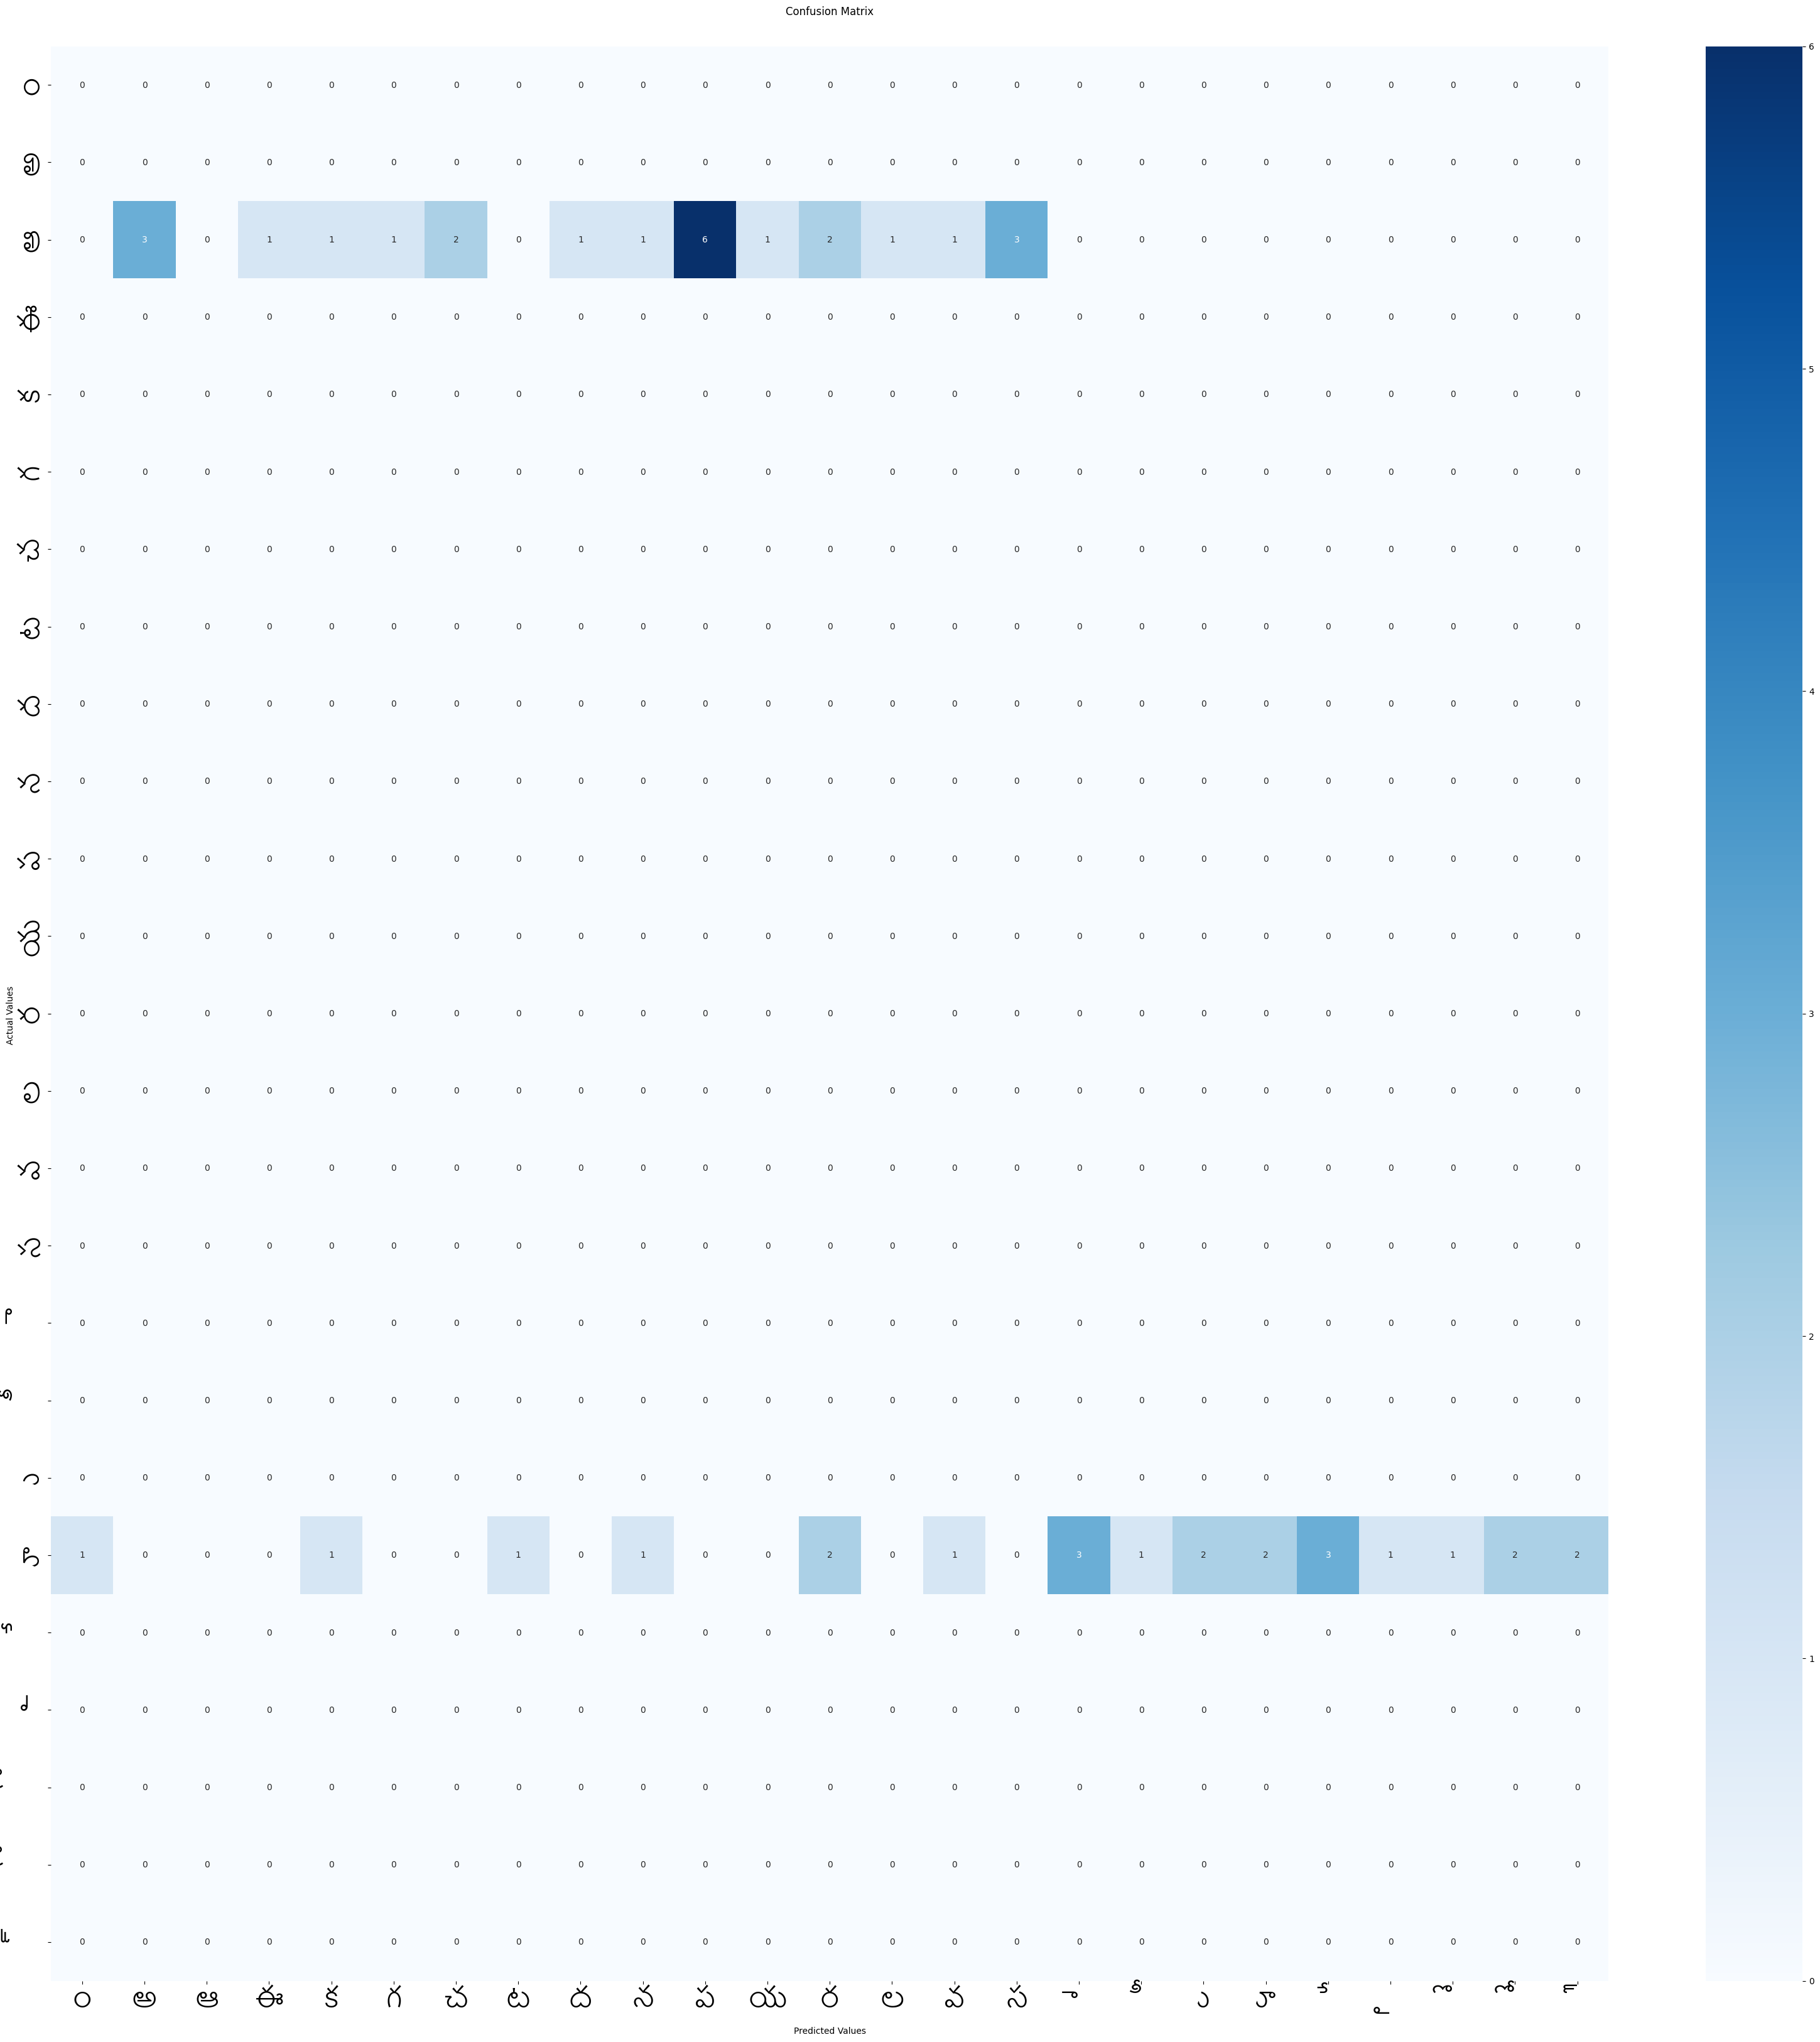

In [37]:
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
labelspred=[]
labelstrue=[]
for i,j in zip(predchar,tgtchar):
  if( i.strip()!=''  )  :
    labelspred.append(i)
    labelstrue.append(j)
import matplotlib.ticker as mticker
from matplotlib.font_manager import FontProperties
hindi_font = FontProperties(fname = 'Nirmala.ttf')
fontdict = {'fontsize': 30}
data = confusion_matrix(labelspred,labelstrue)


import seaborn as sns
fig = plt.figure(figsize=(40,40))
ax = sns.heatmap(data, annot=True, cmap='Blues')

ax.set_title('Confusion Matrix\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
## Ticket labels - List must be in alphabetical order
ax.set_xticklabels(np.unique(labelstrue+labelspred),fontdict=fontdict,fontproperties=hindi_font)
ax.set_yticklabels(np.unique(labelstrue+labelspred),fontdict=fontdict,fontproperties=hindi_font)

## Display the visualization of the Confusion Matrix.
plt.show()

In [38]:
maxlengthword=0
for i in actual:
  if(len(i)>maxlengthword):
    maxlengthword=len(i)


In [39]:

total_words=np.zeros(maxlengthword+1)
total_correct=np.zeros(maxlengthword+1)
total_wrong=np.zeros(maxlengthword+1)

html_str = """
    <br>
      <table style="border:2px solid black; border-collapse:collapse">
      <tr>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Word Length</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Total Words</strong> </th>
      <th scope="row" style="border:1px solid black;background-color:#3498DB;color:white;padding:10px;text-align:left"> <strong>Accuracy</strong> </th></tr>
      """
for (i,j) in zip(actual,predict):
  total_words[len(i)]+=1
  if(i==j):
    total_correct[len(i)]+=1
  else:
    total_wrong[len(i)]+=1

for i in range(maxlengthword):

  if(total_words[i]!=0):
    html_str+="""<tr> <td scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </th>
      <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </th>
      <th scope="row" style="border:1px solid black;padding:10px;text-align:left"> <strong>{}</strong> </th></tr>
      """.format( str(i),str(int(total_words[i])),str("{:.2f}".format(total_correct[i]*100/total_words[i])))
html_str += """</tr></table>"""

display(html_print(html_str))
